In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm.auto import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/scikit/')
from tools import derive_var,read_and_proc,preproc_noensemble,plotting
from tools.mlr import mlr,proc_mlrfcst,maria_IO
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
#sys.path.insert(2, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/')
#import feature_select
#from dask.distributed import Client
#client = Client(processes=True, threads_per_worker=1,n_workers=2)
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

/tmp/ipykernel_2136606/2721527182.py:24: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


In [2]:
def forward_diff(arrayin=None,delta=None,axis=None,LT=1):
    result = []
    if axis==0:
        for i in range(0,arrayin.shape[axis]-LT):
            temp = (arrayin[i+LT,:]-arrayin[i,:])/(LT*delta)
            result.append(temp)
        return np.asarray(result)
    
class retrieve_cartesian:
    def __init__(self,PCA_dict=None,Af_dict=None,numcomp=[11,11,15],LT=None,forecastPC=None,target='all',suffix=None):
        self.PCA_dict=PCA_dict
        self.numcomp=numcomp
        self.forecastPC = forecastPC
        self.LT = LT
        self.target=target
        self.suffix=suffix
        
    def get_time_diff_terms(self,inputvar=None,LT=None,wantvar=None):
        def _get_time_diff(array=None,timedelta=60*60,LT=None):
            store = []
            for exp in array:
                a = forward_diff(exp,timedelta,0,LT)
                if a.shape[0]>0:
                    azero = np.zeros((LT,exp.shape[-1]))
                    store.append(np.asarray(a))
                    #store.append(np.concatenate((a,azero),axis=0))
                else:
                    continue
                    #store.append(np.zeros((exp.shape[0],exp.shape[-1])))
            return store
        
        storedict = {}
        for wantvarZ,wantvarN in enumerate(wantvar):
            storedict[wantvarN] = _get_time_diff(array=inputvar[wantvarZ],LT=LT)
        return storedict
    
    def _pop_valid_test(self,examplist=None,validindex=None,testindex=None):
        [examplist.pop(i) for i in validindex]
        [examplist.pop(i) for i in testindex]
        return None
        
    def windrates_real(self,uvwheatpath=None,LT=None,category='train',validindex=[1,6],testindex=[2,12]):
        u = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['u'] for lime in tqdm(range(1,21))].copy()
        v = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['v'] for lime in tqdm(range(1,21))].copy()
        w = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['w'] for lime in tqdm(range(1,21))].copy()
        theta = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['theta'] for lime in tqdm(range(1,21))].copy()
        
        if category=='train':
            self._pop_valid_test(u,validindex,testindex)
            self._pop_valid_test(v,validindex,testindex)
            self._pop_valid_test(w,validindex,testindex)
            self._pop_valid_test(theta,validindex,testindex)
            assert len(u)==16, 'wrong train-valid-test separation!'
            dtermsT = self.get_time_diff_terms(inputvar=[u,v,w,theta],LT=LT,wantvar=['u','v','w','theta'])
        elif category=='valid':
            uv = [u[index] for index in validindex]
            vv = [v[index] for index in validindex]
            wv = [w[index] for index in validindex]
            thetav = [theta[index] for index in validindex]
            del u,v,w,theta
            gc.collect()
            dtermsT = self.get_time_diff_terms(inputvar=[uv,vv,wv,thetav],LT=LT,wantvar=['u','v','w','theta'])
        elif category=='test':
            ut = [u[index] for index in testindex]
            vt = [v[index] for index in testindex]
            wt = [w[index] for index in testindex]
            thetat = [theta[index] for index in testindex]            
            del u,v,w,theta
            gc.collect()
            dtermsT = self.get_time_diff_terms(inputvar=[ut,vt,wt,thetat],LT=LT,wantvar=['u','v','w','theta'])            
        
        dudt = np.concatenate([testx for testx in dtermsT['u']],axis=0)
        dvdt = np.concatenate([testx for testx in dtermsT['v']],axis=0)
        dwdt = np.concatenate([testx for testx in dtermsT['w']],axis=0)
        dthdt = np.concatenate([testx for testx in dtermsT['theta']],axis=0)
        del dtermsT
        gc.collect()
        return dudt,dvdt,dwdt,dthdt

Real wind data
--------------------------------------------
Now we read in the real WRF 24-hr radial and tangential wind intensification rates. We are performing the analysis on Haiyan ensemble

In [4]:
! pwd

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/haiyan


In [5]:
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
a = [read_and_proc.depickle(path+'testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()

haiyan_u = np.concatenate([read_and_proc.depickle(path+'testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'] for lime in tqdm(range(1,21))],axis=0)
haiyan_v = np.concatenate([read_and_proc.depickle(path+'testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['v'] for lime in tqdm(range(1,21))],axis=0)
haiyan_w = np.concatenate([read_and_proc.depickle(path+'testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['w'] for lime in tqdm(range(1,21))],axis=0)
haiyan_theta = np.concatenate([read_and_proc.depickle(path+'testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['theta'] for lime in tqdm(range(1,21))],axis=0)
haiyan_rad = np.concatenate([read_and_proc.depickle(path+'testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['rad'] for lime in tqdm(range(1,21))],axis=0)
haiyan_qv = np.concatenate([read_and_proc.depickle(path+'testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['qv'] for lime in tqdm(range(1,21))],axis=0)

folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/'
PCAdict,dict2 = read_and_proc.depickle(folderpath+'pca/PCA'+'_'+'dict1_g'),read_and_proc.depickle(folderpath+'pca/PCA'+'_'+'dict2_g') #dict1: u,v,w,theta,hdia,rad; dict2:qv,ir
PCAdict['qv'] = (dict2['qv'])
PCAdict['ir'] = (dict2['ir'])

dims = ['sample','flatarray']
coords = dict(sample=np.linspace(0,haiyan_u.shape[0]-1,haiyan_u.shape[0]),flatarray=np.linspace(0,haiyan_u.shape[1]-1,haiyan_u.shape[1]))
ds = xr.Dataset(coords=coords)
haiyan_data=preproc_haiyan.build_a_xarray_dataset(ds=ds,varname=['u','v','w','theta','rad','qv'],varfile=[haiyan_u,haiyan_v,haiyan_w,haiyan_theta,haiyan_rad,haiyan_qv],dims=dims,coords=coords)
del haiyan_u,haiyan_v,haiyan_w,haiyan_theta,haiyan_qv
gc.collect()
#TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/mem1_smooth_preproc_dict1b_g

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator IncrementalPCA from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


1098

Principal components
--------------------------------------------
Examine the RAD PC sstatistics in the Haiyan ensemble

In [6]:
RADtimeseries = PCAdict['rad'].transform(haiyan_data['rad'].data)[:,0:10]

/tmp/ipykernel_2136606/1604305873.py:8: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


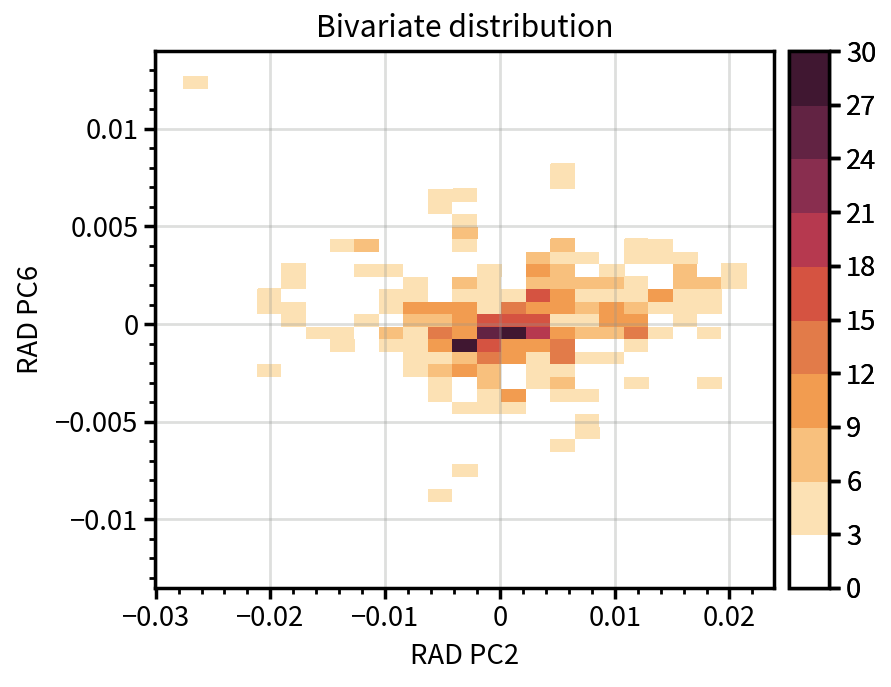

In [11]:
import pandas as pd
df = pd.DataFrame({"rad2": RADtimeseries[:,1].flatten(), \
                   "rad6": RADtimeseries[:,5].flatten()})
#plot.rc.metacolor = 'w'
#plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 13,'linewidth':1.25})
#plot.rc.axesfacecolor = 'k'
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.095,refaspect=1.1531)
axs[0].format(ylabel='RAD PC6',xlabel='RAD PC2',title=f'Bivariate distribution') #variance:{(pcex[index[i]]*100):.1f}%'
axs[0].grid(alpha=0.3,color='gray',linewidth=1)
sbss = sns.histplot(x=df["rad2"],y=df["rad6"],ax=axs[0],cmap='Fire',cbar=True)
#plt.savefig('../figures/0530_fig1.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

In [6]:
a = [read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()
del a
gc.collect()

  0%|          | 0/20 [00:00<?, ?it/s]

313

In [12]:
def _back_to_exp(timeseries=None,divider=None):
    printout = [timeseries[0:divider[0],:]]
    for i in range(1,19):
        printout.append(timeseries[divider[i-1]:divider[i],:])
    printout.append(timeseries[divider[-2]:,:])
    return printout

def get_surf(index=None):
    surfU_0,surfV_0 = np.asarray(expU[index]).reshape(expU[index].shape[0],10,360,int(expU[index].shape[1]/10/360))[:,0,...],np.asarray(expV[index]).reshape(expV[index].shape[0],10,360,int(expV[index].shape[1]/10/360))[:,0,...]
    #surfU_1,surfV_1 = np.asarray(expU[1]).reshape(expU[1].shape[0],10,360,int(expU[1].shape[1]/10/360))[:,0,...],np.asarray(expV[1]).reshape(expV[1].shape[0],10,360,int(expV[1].shape[1]/10/360))[:,0,...]
    surWSPD_0 = np.max(np.nanmean(np.sqrt(surfU_0**2+surfV_0**2),axis=1),axis=1)
    return surWSPD_0

PCRAD = _back_to_exp(RADtimeseries[:,:],divider)
expU,expV,expQV = _back_to_exp(haiyan_data['u'],divider),_back_to_exp(haiyan_data['v'],divider),_back_to_exp(haiyan_data['qv'],divider)
maxmeanWSURF = [get_surf(index) for index in range(20)]
#del haiyan_data['u'],haiyan_data['v'],haiyan_data['qv']
#gc.collect()

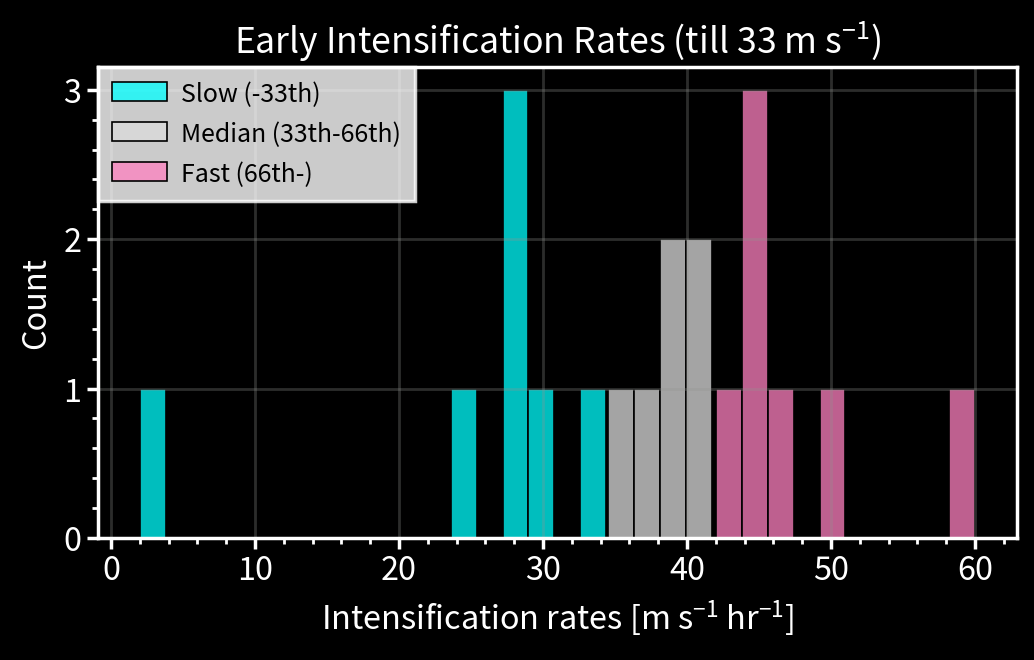

In [9]:
#sns.histplot(inten_rate,binwidth=0.03)
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.595,refaspect=1.9531)
axs[0].format(ylabel='Count',xlabel='Intensification rates [m s$^{-1}$ hr$^{-1}$]',title=r'Early Intensification Rates (till 33 m s$^{-1}$)') #variance:{(pcex[index[i]]*100):.1f}%'
axs[0].grid(alpha=0.3,color='gray',linewidth=1)
sns.histplot(np.ma.masked_greater(inten_rate,0.56*60),binwidth=0.03*60,color='cyan',ax=axs[0],label='Slow (-33th)')
sns.histplot(np.ma.masked_less(np.ma.masked_greater(inten_rate,0.69*60),0.56*60),binwidth=0.03*60,color='gainsboro',ax=axs[0],label='Median (33th-66th)')
sns.histplot(np.ma.masked_less(inten_rate,0.69*60),binwidth=0.03*60,color='pink',ax=axs[0],label='Fast (66th-)')
axs[0].legend(loc='ul',ncols=1,prop={'size':10})
plt.savefig('../figures/0530_fig3.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

In [14]:
import pandas as pd
inten_rate = [(maxmeanWSURF[i][np.abs(maxmeanWSURF[i]-33).argmin()]-maxmeanWSURF[i][0])/(np.abs(maxmeanWSURF[i]-33).argmin())*(60) for i in range(20)]
index33 = [(np.abs(maxmeanWSURF[i]-33).argmin()) for i in range(20)]
ds = pd.DataFrame({'inten_rate':inten_rate,'index':index33})
#(np.argwhere((np.asarray(inten_rate)>0.56*60 & np.asarray(inten_rate)<0.69*60)))

In [15]:
import itertools
def stack_padding(l):
    return np.column_stack((itertools.zip_longest(*l, fillvalue=np.nan)))

In [59]:
ds

,inten_rate,index
0,28.947397,37
1,44.616595,25
2,38.761047,31
3,36.957335,33
4,27.994714,33
5,44.865033,25
6,50.446499,21
7,40.041166,22
8,47.117320,21
9,41.997833,27


In [60]:
nopac = [PCRAD[i][:ds['index'][i],1][-20:] for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19]]

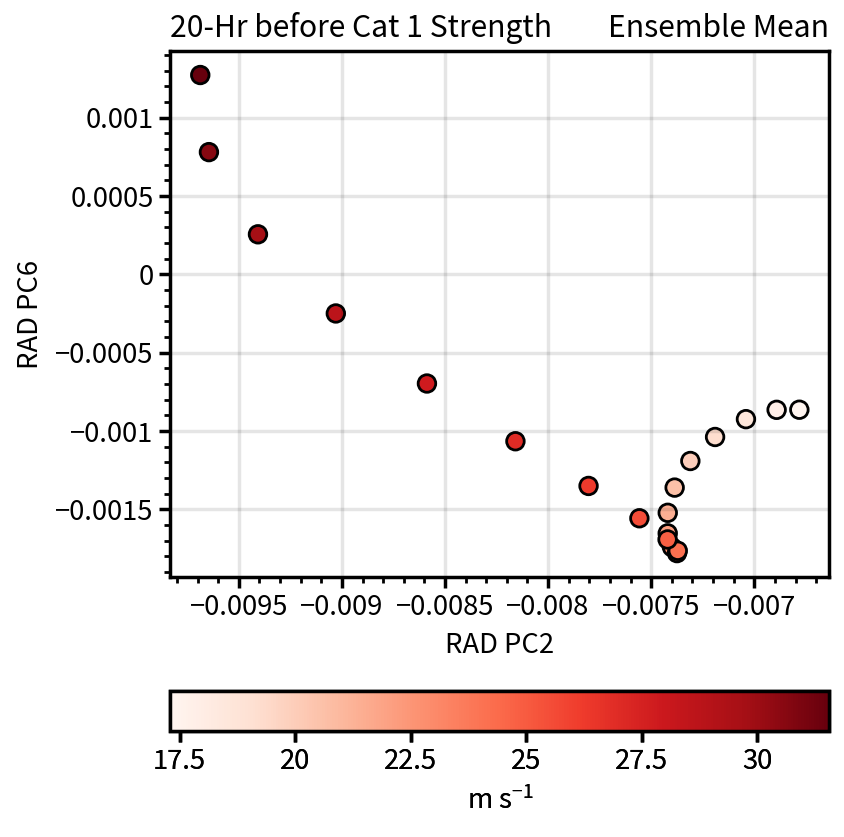

In [89]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.295,refaspect=1.2531)
ct0=axs[0].scatter(np.mean(np.asarray(nopac),axis=0),np.mean(np.asarray([PCRAD[i][:ds['index'][i],5][-20:] for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19]]),axis=0),
           s= 40, c = np.mean(np.asarray([maxmeanWSURF[i][:ds['index'][i]][-20:] for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19]]),axis=0),cmap='Reds',linewidths=1,edgecolors='k')
axs.format(xlabel='RAD PC2',ylabel='RAD PC6',ltitle='20-Hr before Cat 1 Strength',rtitle='Ensemble Mean')
plt.colorbar(ct0,loc='b',label='m s$^{-1}$')
plt.savefig('../figures/proposal/RADtrajs.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()


In [ ]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.595,refaspect=1.1531)
ct0 = axs[0].scatter(PCRAD) #variance:{(pcex[index[i]]*100):.1f}%'
for i in range(len(slowinten)):
    axs[0].scatter(np.ma.masked_where(slowinten[i]>59,slowPC2[i]),np.ma.masked_where(slowinten[i]>59,slowPC6[i]), 
                   s= 10, c = slowinten[i], cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59,alpha=0.3)
#index = 12
ct1 = axs[1].scatter(np.ma.masked_where(meanWSURF_med>59,meanPC2_med),np.ma.masked_where(meanWSURF_med>59,meanPC6_med), 
                    s= 40, c = meanWSURF_med, cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59) #variance:{(pcex[index[i]]*100):.1f}%'
for i in range(len(medinten)):
    axs[1].scatter(np.ma.masked_where(medinten[i]>59,medPC2[i]),np.ma.masked_where(medinten[i]>59,medPC6[i]), 
                   s= 10, c = medinten[i], cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59,alpha=0.3)
ct2 = axs[2].scatter(np.ma.masked_where(meanWSURF_quick>59,meanPC2_quick),np.ma.masked_where(meanWSURF_quick>59,meanPC6_quick), 
                    s= 40, c = meanWSURF_quick, cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59)
for i in range(len(quickinten)):
    axs[2].scatter(np.ma.masked_where(quickinten[i]>59,quickPC2[i]),np.ma.masked_where(quickinten[i]>59,quickPC6[i]), 
                   s= 10, c = quickinten[i], cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59,alpha=0.3)
axs.grid(alpha=0.3,color='gray',linewidth=1)
#plt.colorbar(ct0,label='Surface Wind Speed (m s$^{-1}$)')
#axs.format(ylabel='RAD PC6',xlabel='RAD PC2',suptitle=r'Trajectories in RAD PC2-PC6 parameter space [Conditional sampling]')
#axs[0].format(title=r'Early intensification: Slow members')
#axs[1].format(title=r'Early intensification: Medium members')
#axs[2].format(title=r'Early intensification: Fast members')
#plt.savefig('../figures/0530_fig4.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

PCRAD

Moisture heterogeneity
------------------------------------

In [24]:
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,207,208)*3),np.linspace(0,207,208)*3))

import pandas as pd
inten_rate = [(maxmeanWSURF[i][np.abs(maxmeanWSURF[i]-33).argmin()]-maxmeanWSURF[i][0])/(np.abs(maxmeanWSURF[i]-33).argmin())*(60) for i in range(20)]
ds = pd.DataFrame({'inten_rate':inten_rate})
lowrate_indices = ds[(ds.inten_rate<0.56*60)].index
midrate_indices = list(ds[(ds.inten_rate>0.56*60) & (ds.inten_rate<0.69*60)].index)
highrate_indices = ds[(ds.inten_rate>0.69*60)].index

In [32]:
low800qv = [(expQV[index].data.reshape(expQV[index].shape[0],10,360,208))[np.abs(maxmeanWSURF[index]-33).argmin()-12:np.abs(maxmeanWSURF[index]-33).argmin(),2,...] for index in lowrate_indices]
med800qv = [(expQV[index].data.reshape(expQV[index].shape[0],10,360,208))[np.abs(maxmeanWSURF[index]-33).argmin()-12:np.abs(maxmeanWSURF[index]-33).argmin(),2,...] for index in midrate_indices]
high800qv = [(expQV[index].data.reshape(expQV[index].shape[0],10,360,208))[np.abs(maxmeanWSURF[index]-33).argmin()-12:np.abs(maxmeanWSURF[index]-33).argmin(),2,...] for index in highrate_indices]

/tmp/7373146/ipykernel_2929958/360885226.py:5: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.grid(alpha=0.3,color='gray',linewidth=1)


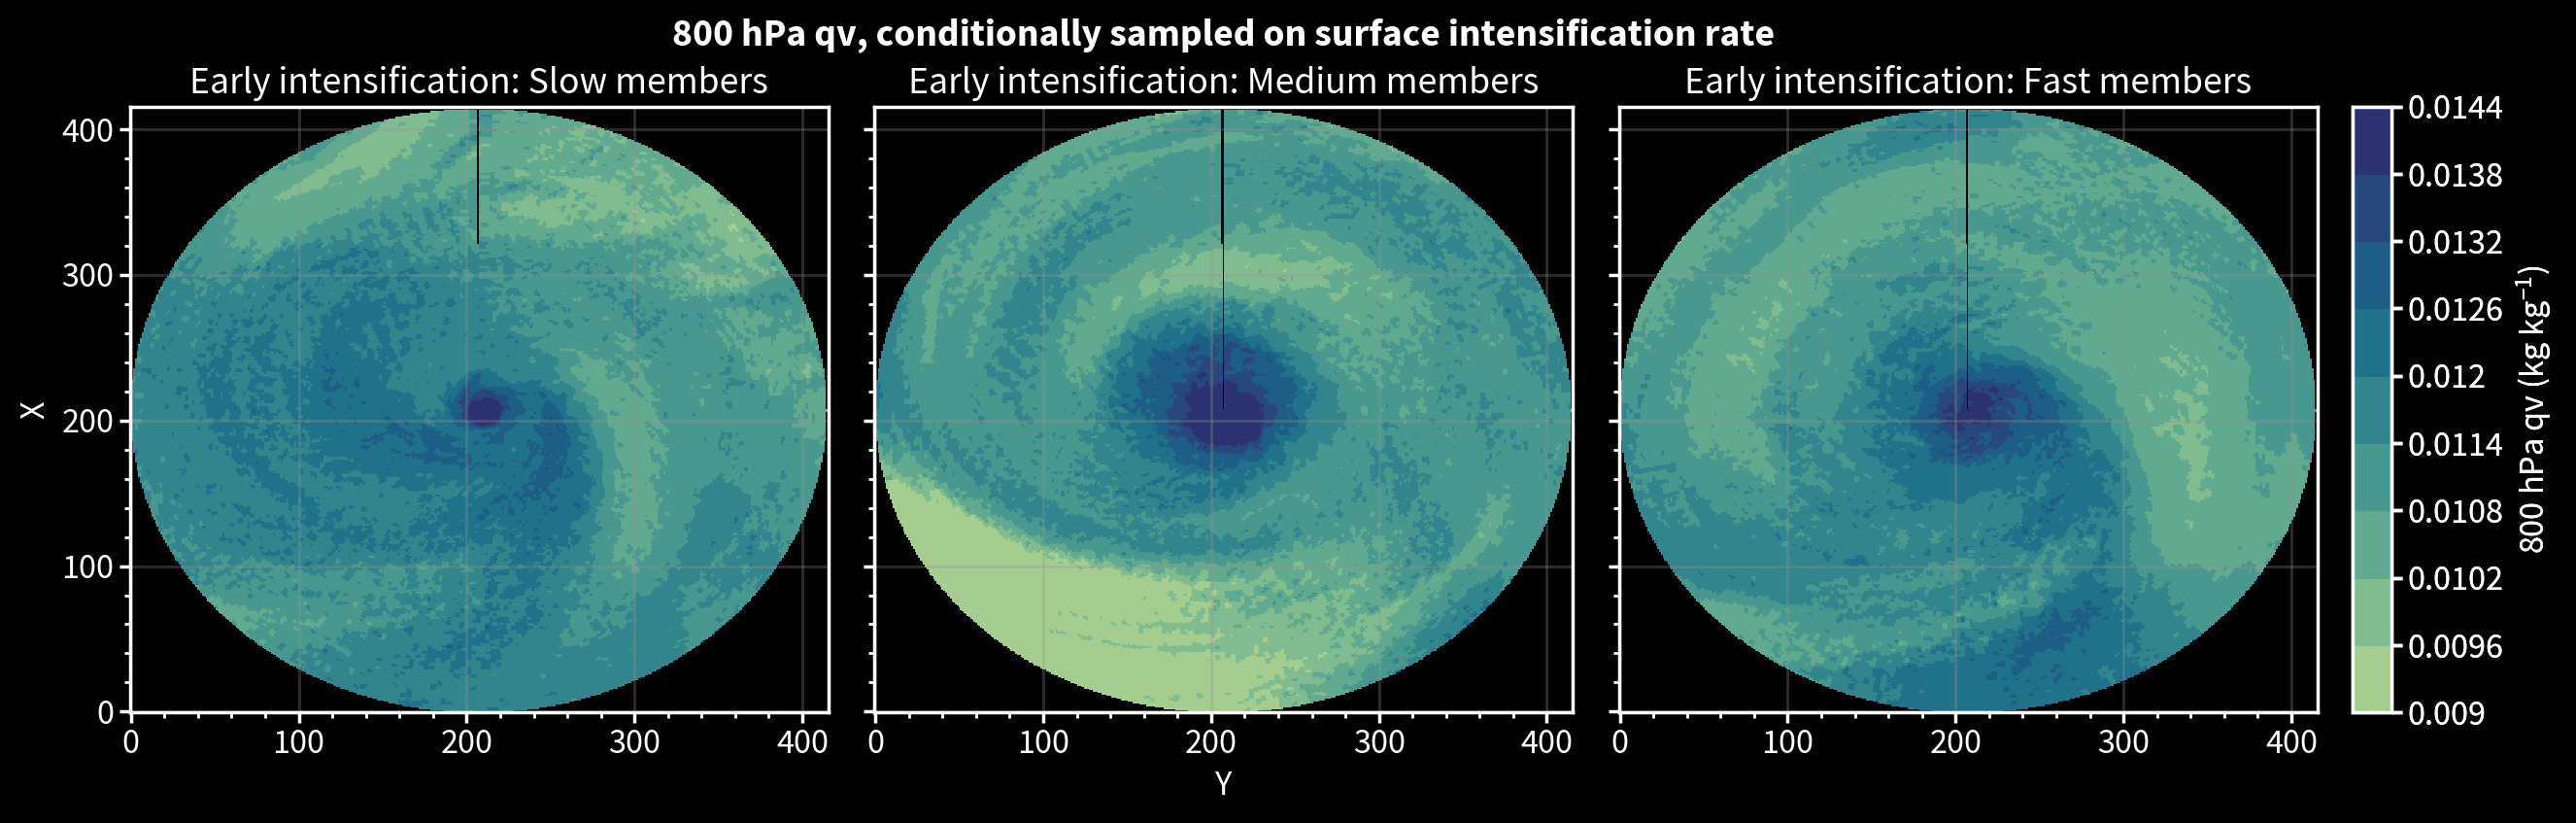

In [33]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.595,refaspect=1.1531)
ct0 = axs[0].pcolormesh(np.ma.masked_equal(np.fliplr(np.flipud((read_and_proc.proc_tocart(np.nanmean(low800qv[0],axis=0),ANGLE,True,False)))),0), cmap='crest',vmin=0.009,vmax=0.015)
ct1 = axs[1].pcolormesh(np.ma.masked_equal(np.fliplr(np.flipud((read_and_proc.proc_tocart(np.nanmean(med800qv[0],axis=0),ANGLE,True,False)))),0), cmap='crest',vmin=0.009,vmax=0.015)
ct2 = axs[2].pcolormesh(np.ma.masked_equal(np.fliplr(np.flipud((read_and_proc.proc_tocart(np.nanmean(high800qv[0],axis=0),ANGLE,True,False)))),0), cmap='crest',vmin=0.009,vmax=0.015)
axs.grid(alpha=0.3,color='gray',linewidth=1)
plt.colorbar(ct0,label='800 hPa qv (kg kg$^{-1}$)')
axs.format(ylabel='X',xlabel='Y',suptitle=r'800 hPa qv, conditionally sampled on surface intensification rate')
axs[0].format(title=r'Early intensification: Slow members')
axs[1].format(title=r'Early intensification: Medium members')
axs[2].format(title=r'Early intensification: Fast members')
plt.savefig('../figures/0530_fig5.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

/tmp/7373146/ipykernel_2929958/3086405027.py:6: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.grid(alpha=0.3,color='gray',linewidth=1)


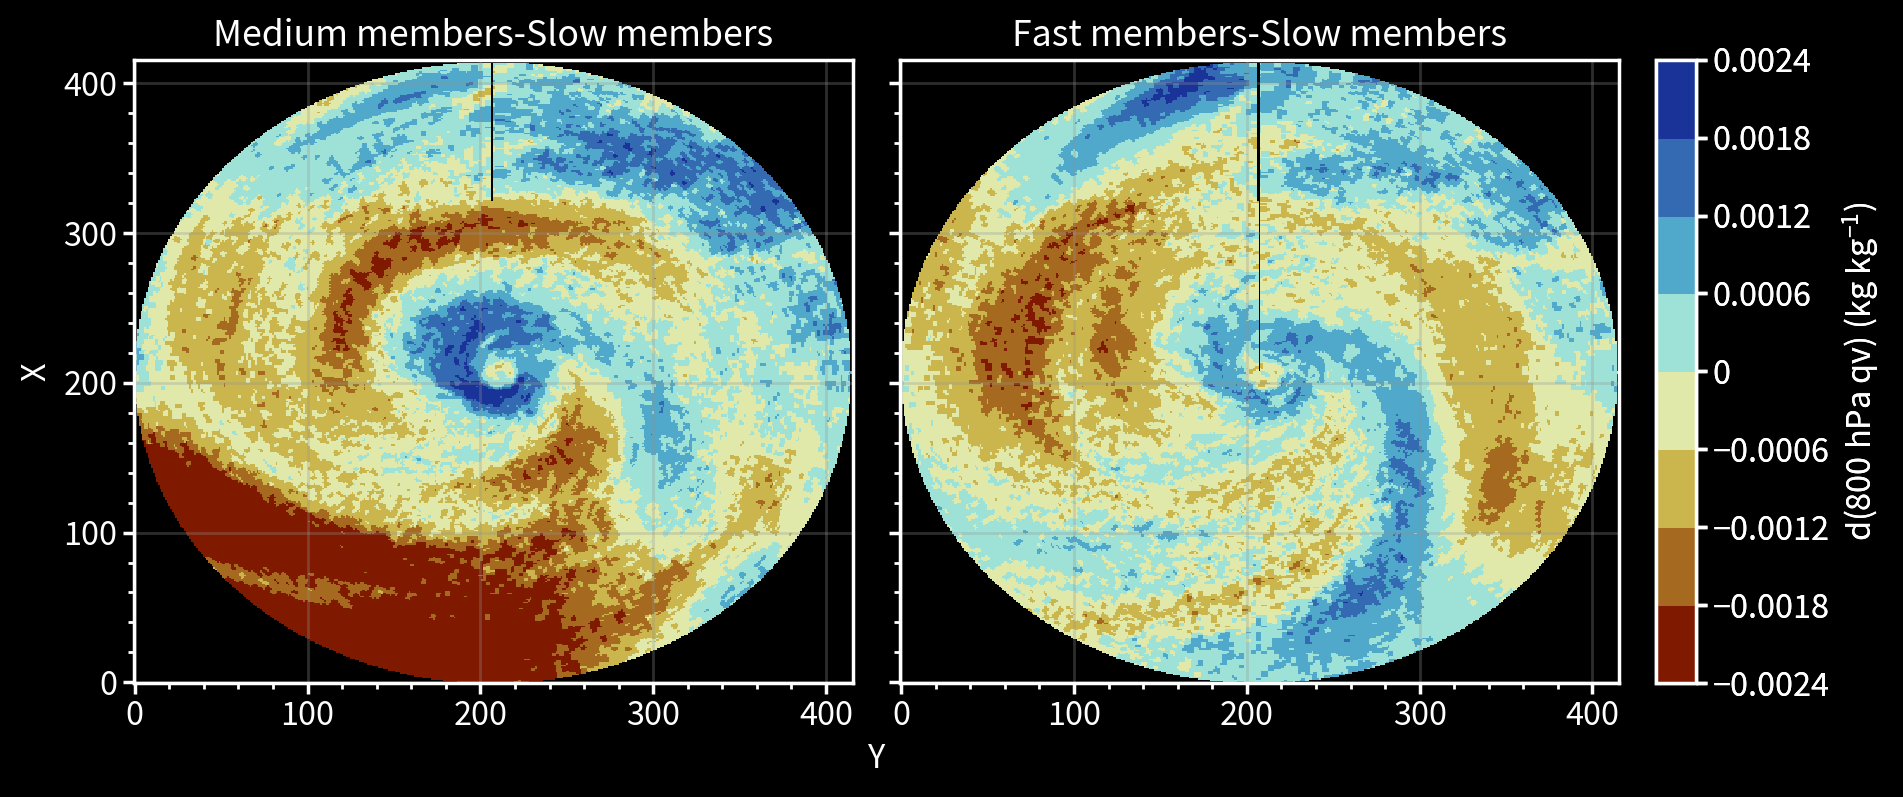

In [41]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=3.595,refaspect=1.1531)
ct0 = axs[0].pcolormesh(np.ma.masked_equal(np.fliplr(np.flipud((read_and_proc.proc_tocart(np.nanmean(med800qv[0],axis=0),ANGLE,True,False))))-\
                                                              np.fliplr(np.flipud((read_and_proc.proc_tocart(np.nanmean(low800qv[0],axis=0),ANGLE,True,False)))),0), cmap='roma',vmin=-0.0028,vmax=0.0028)
ct1 = axs[1].pcolormesh(np.ma.masked_equal(np.fliplr(np.flipud((read_and_proc.proc_tocart(np.nanmean(high800qv[0],axis=0),ANGLE,True,False))))-\
                                                              np.fliplr(np.flipud((read_and_proc.proc_tocart(np.nanmean(low800qv[0],axis=0),ANGLE,True,False)))),0), cmap='roma',vmin=-0.0028,vmax=0.0028)
axs.grid(alpha=0.3,color='gray',linewidth=1)
plt.colorbar(ct0,label='d(800 hPa qv) (kg kg$^{-1}$)')
axs.format(ylabel='X',xlabel='Y')#,suptitle=r'800 hPa qv, conditionally sampled on surface intensification rate')
axs[0].format(title=r'Medium members-Slow members')
axs[1].format(title=r'Fast members-Slow members')
plt.savefig('../figures/0530_fig6.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

Intensification in PC2-PC6 parameter space
-------------------------------------------

In [80]:
import itertools
def stack_padding(l):
    return np.column_stack((itertools.zip_longest(*l, fillvalue=np.nan)))

# Intensification Rates
slowinten = stack_padding([maxmeanWSURF[int(obj)] for obj in list(ds[(ds.inten_rate<0.56*60)].index)])
medinten = stack_padding([maxmeanWSURF[int(obj)] for obj in list(ds[(ds.inten_rate>0.56*60) & (ds.inten_rate<0.69*60)].index)])
quickinten = stack_padding([maxmeanWSURF[int(obj)] for obj in list(ds[(ds.inten_rate>0.69*60)].index)])
# PC2
slowPC2 = stack_padding([PCRAD[int(obj)][0:,1] for obj in list(ds[(ds.inten_rate<0.56*60)].index)])
medPC2 = stack_padding([PCRAD[int(obj)][0:,1] for obj in list(ds[(ds.inten_rate>0.56*60) & (ds.inten_rate<0.69*60)].index)])
quickPC2 = stack_padding([PCRAD[int(obj)][0:,1] for obj in list(ds[(ds.inten_rate>0.69*60)].index)])
# PC6
slowPC6 = stack_padding([PCRAD[int(obj)][0:,5] for obj in list(ds[(ds.inten_rate<0.56*60)].index)])
medPC6 = stack_padding([PCRAD[int(obj)][0:,5] for obj in list(ds[(ds.inten_rate>0.56*60) & (ds.inten_rate<0.69*60)].index)])
quickPC6 = stack_padding([PCRAD[int(obj)][0:,5] for obj in list(ds[(ds.inten_rate>0.69*60)].index)])

/tmp/ipykernel_4058605/4185740717.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.column_stack((itertools.zip_longest(*l, fillvalue=np.nan)))


In [81]:
meanWSURF_slow,meanPC2_slow,meanPC6_slow = np.nanmean(slowinten,axis=0),np.nanmean(slowPC2,axis=0),np.nanmean(slowPC6,axis=0)
meanWSURF_med,meanPC2_med,meanPC6_med = np.nanmean(medinten,axis=0),np.nanmean(medPC2,axis=0),np.nanmean(medPC6,axis=0)
meanWSURF_quick,meanPC2_quick,meanPC6_quick = np.nanmean(quickinten,axis=0),np.nanmean(quickPC2,axis=0),np.nanmean(quickPC6,axis=0)

/tmp/ipykernel_4058605/1905770794.py:18: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.grid(alpha=0.3,color='gray',linewidth=1)


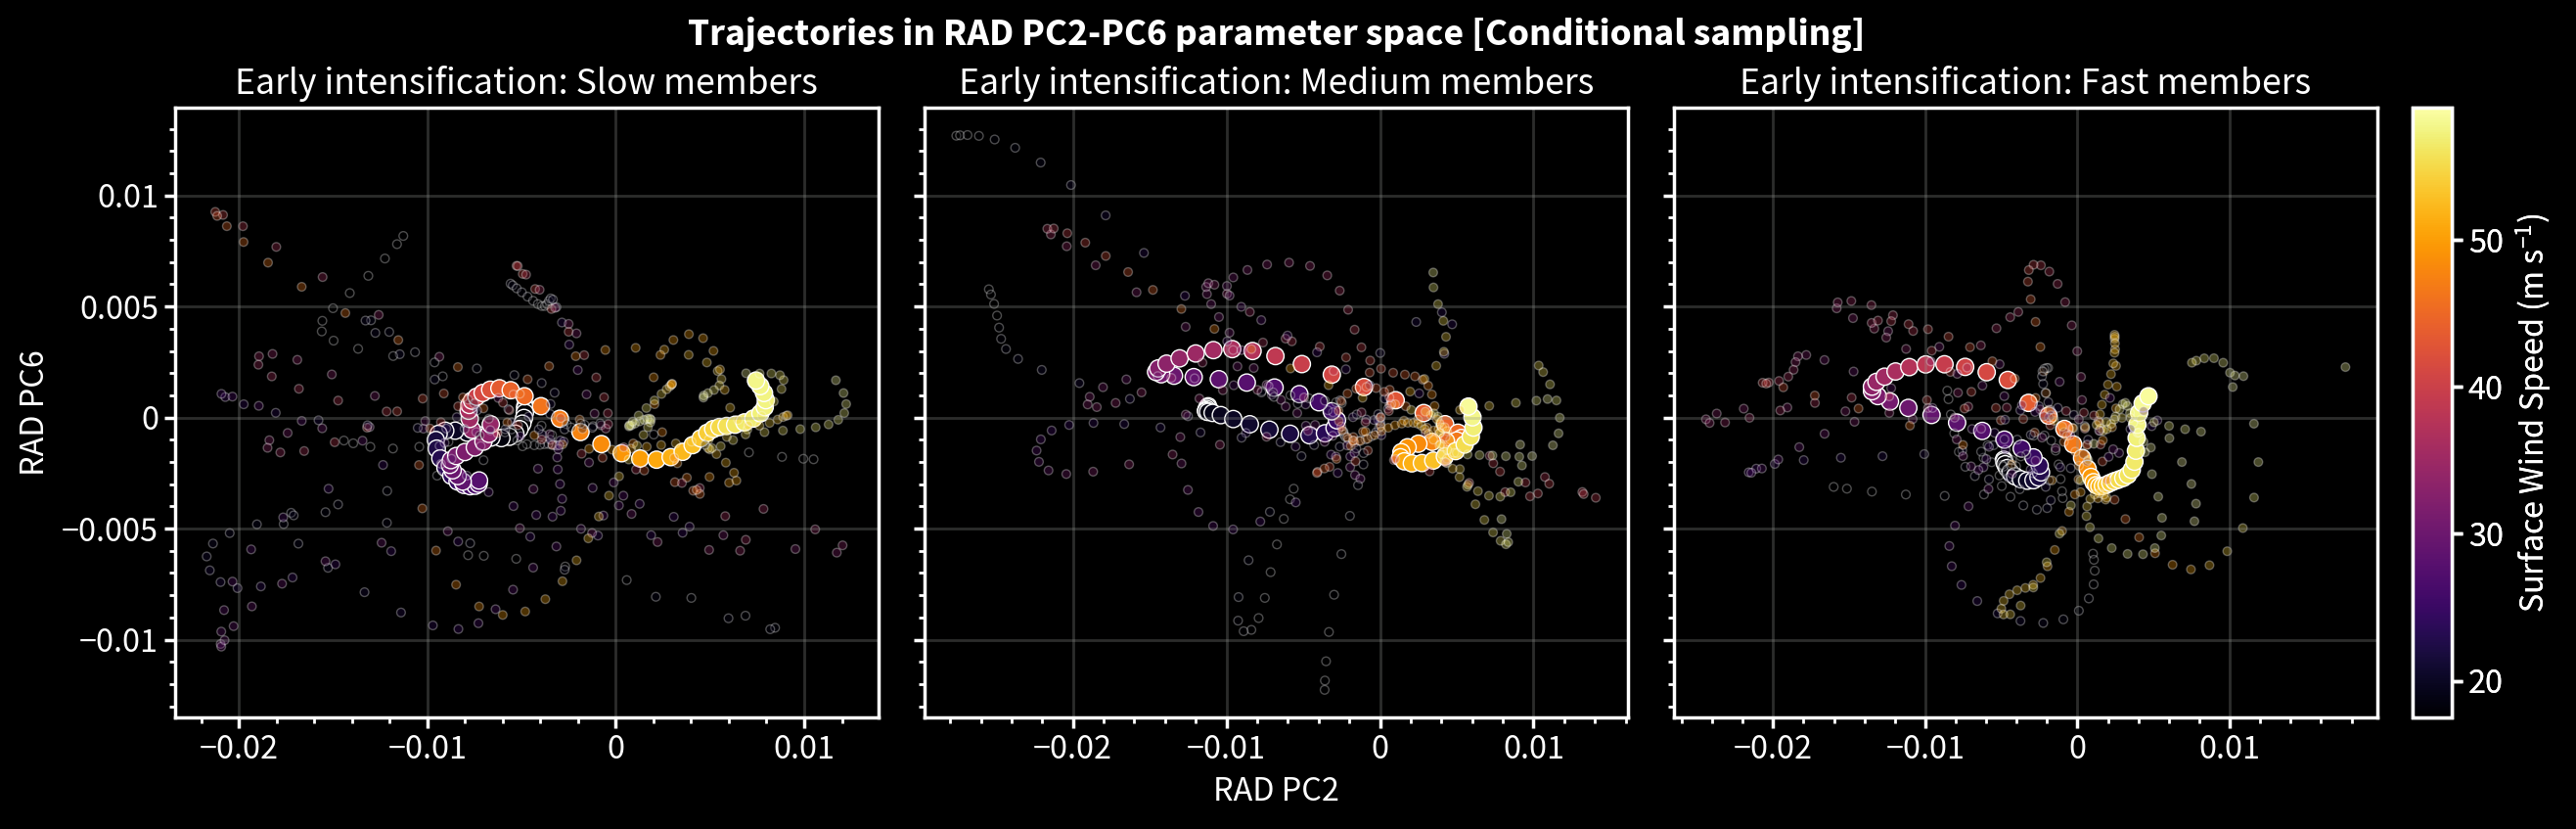

In [92]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.595,refaspect=1.1531)
ct0 = axs[0].scatter(np.ma.masked_where(meanWSURF_slow>59,meanPC2_slow),np.ma.masked_where(meanWSURF_slow>59,meanPC6_slow), 
                    s= 40, c = meanWSURF_slow, cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59) #variance:{(pcex[index[i]]*100):.1f}%'
for i in range(len(slowinten)):
    axs[0].scatter(np.ma.masked_where(slowinten[i]>59,slowPC2[i]),np.ma.masked_where(slowinten[i]>59,slowPC6[i]), 
                   s= 10, c = slowinten[i], cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59,alpha=0.3)
#index = 12
ct1 = axs[1].scatter(np.ma.masked_where(meanWSURF_med>59,meanPC2_med),np.ma.masked_where(meanWSURF_med>59,meanPC6_med), 
                    s= 40, c = meanWSURF_med, cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59) #variance:{(pcex[index[i]]*100):.1f}%'
for i in range(len(medinten)):
    axs[1].scatter(np.ma.masked_where(medinten[i]>59,medPC2[i]),np.ma.masked_where(medinten[i]>59,medPC6[i]), 
                   s= 10, c = medinten[i], cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59,alpha=0.3)
ct2 = axs[2].scatter(np.ma.masked_where(meanWSURF_quick>59,meanPC2_quick),np.ma.masked_where(meanWSURF_quick>59,meanPC6_quick), 
                    s= 40, c = meanWSURF_quick, cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59)
for i in range(len(quickinten)):
    axs[2].scatter(np.ma.masked_where(quickinten[i]>59,quickPC2[i]),np.ma.masked_where(quickinten[i]>59,quickPC6[i]), 
                   s= 10, c = quickinten[i], cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59,alpha=0.3)
axs.grid(alpha=0.3,color='gray',linewidth=1)
plt.colorbar(ct0,label='Surface Wind Speed (m s$^{-1}$)')
axs.format(ylabel='RAD PC6',xlabel='RAD PC2',suptitle=r'Trajectories in RAD PC2-PC6 parameter space [Conditional sampling]')
axs[0].format(title=r'Early intensification: Slow members')
axs[1].format(title=r'Early intensification: Medium members')
axs[2].format(title=r'Early intensification: Fast members')
plt.savefig('../figures/0530_fig4.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

##### Time series clustering

In [9]:
from tslearn.utils import to_time_series_dataset
formatted_WSURF = to_time_series_dataset([timeseries for timeseries in maxmeanWSURF])

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [10]:
from tslearn.clustering import TimeSeriesKMeans
km = TimeSeriesKMeans(n_clusters=3, metric="dtw")
km.fit(formatted_WSURF)

TimeSeriesKMeans(metric='dtw')

In [21]:
ts1,ts2 = [maxmeanWSURF[i] for i in range(20) if km.labels_[i]==1],[maxmeanWSURF[i] for i in range(20) if km.labels_[i]==2]

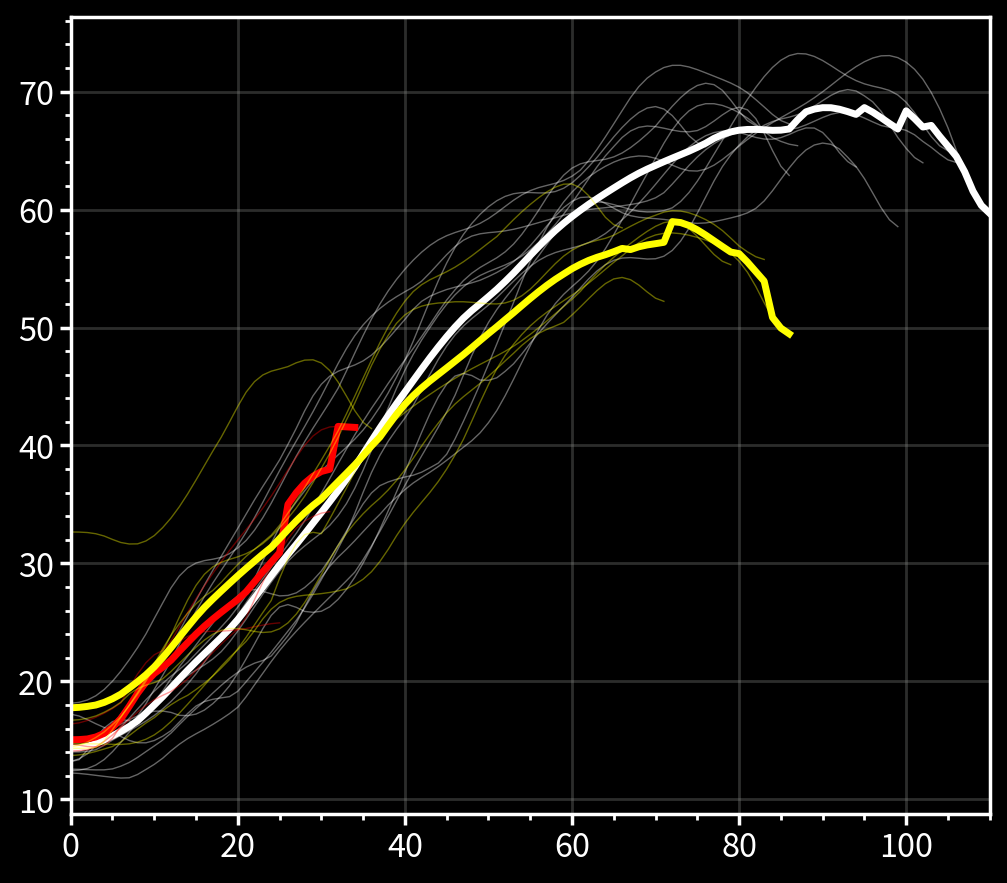

In [72]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.595,refaspect=1.1531)
for i in range(len(ts0)):
    ct = axs[0].plot(ts0[i],linewidths=0.5, colors='w',alpha=0.4) #variance:{(pcex[index[i]]*100):.1f}%'
axs[0].plot(np.nanmean(ts0_WSURF,axis=0),linewidths=2.5, colors='w')
for i in range(len(ts1)):
    ct = axs[0].plot(ts1[i],linewidths=0.5, colors='r',alpha=0.4) #variance:{(pcex[index[i]]*100):.1f}%'
axs[0].plot(np.nanmean(ts1_WSURF,axis=0),linewidths=2.5, colors='r')
for i in range(len(ts2)):
    ct = axs[0].plot(ts2[i],linewidths=0.5, colors='yellow',alpha=0.4)
axs[0].plot(np.nanmean(ts2_WSURF,axis=0),linewidths=2.5, colors='yellow')
axs[0].grid(alpha=0.3,color='gray',linewidth=1)
plt.show()

##### Results

In [39]:
import itertools
def stack_padding(l):
    return np.column_stack((itertools.zip_longest(*l, fillvalue=np.nan)))

ts0_WSURF = stack_padding([maxmeanWSURF[i] for i in range(20) if km.labels_[i]==0])
PC2_0,PC6_0 = stack_padding([PCRAD[i][0:,1] for i in range(20) if km.labels_[i]==0]),stack_padding([PCRAD[i][0:,5] for i in range(20) if km.labels_[i]==0])
meanWSURF,meanPC2,meanPC6 = np.nanmean(ts0_WSURF,axis=0),np.nanmean(PC2_0,axis=0),np.nanmean(PC6_0,axis=0)

/tmp/ipykernel_826189/83314590.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.column_stack((itertools.zip_longest(*l, fillvalue=np.nan)))


In [47]:
ts1_WSURF = stack_padding([maxmeanWSURF[i] for i in range(20) if km.labels_[i]==1])
PC2_1,PC6_1 = stack_padding([PCRAD[i][0:,1] for i in range(20) if km.labels_[i]==1]),stack_padding([PCRAD[i][0:,5] for i in range(20) if km.labels_[i]==1])
meanWSURF_1,meanPC2_1,meanPC6_1 = np.nanmean(ts1_WSURF,axis=0),np.nanmean(PC2_1,axis=0),np.nanmean(PC6_1,axis=0)

ts2_WSURF = stack_padding([maxmeanWSURF[i] for i in range(20) if km.labels_[i]==2])
PC2_2,PC6_2 = stack_padding([PCRAD[i][0:,1] for i in range(20) if km.labels_[i]==2]),stack_padding([PCRAD[i][0:,5] for i in range(20) if km.labels_[i]==2])
meanWSURF_2,meanPC2_2,meanPC6_2 = np.nanmean(ts2_WSURF,axis=0),np.nanmean(PC2_2,axis=0),np.nanmean(PC6_2,axis=0)

/tmp/ipykernel_826189/83314590.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.column_stack((itertools.zip_longest(*l, fillvalue=np.nan)))


In [68]:
print(len((np.where(np.ma.masked_where(meanWSURF>33,meanPC2).mask==False))[0]),len((np.where(np.ma.masked_where(meanWSURF_1>33,meanPC2_1).mask==False))[0]),\
      len((np.where(np.ma.masked_where(meanWSURF_2>33,meanPC2_2).mask==False))[0]))
#np.count_nonzero(arr)

29 26 27


/tmp/ipykernel_826189/1396280588.py:10: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.grid(alpha=0.3,color='gray',linewidth=1)


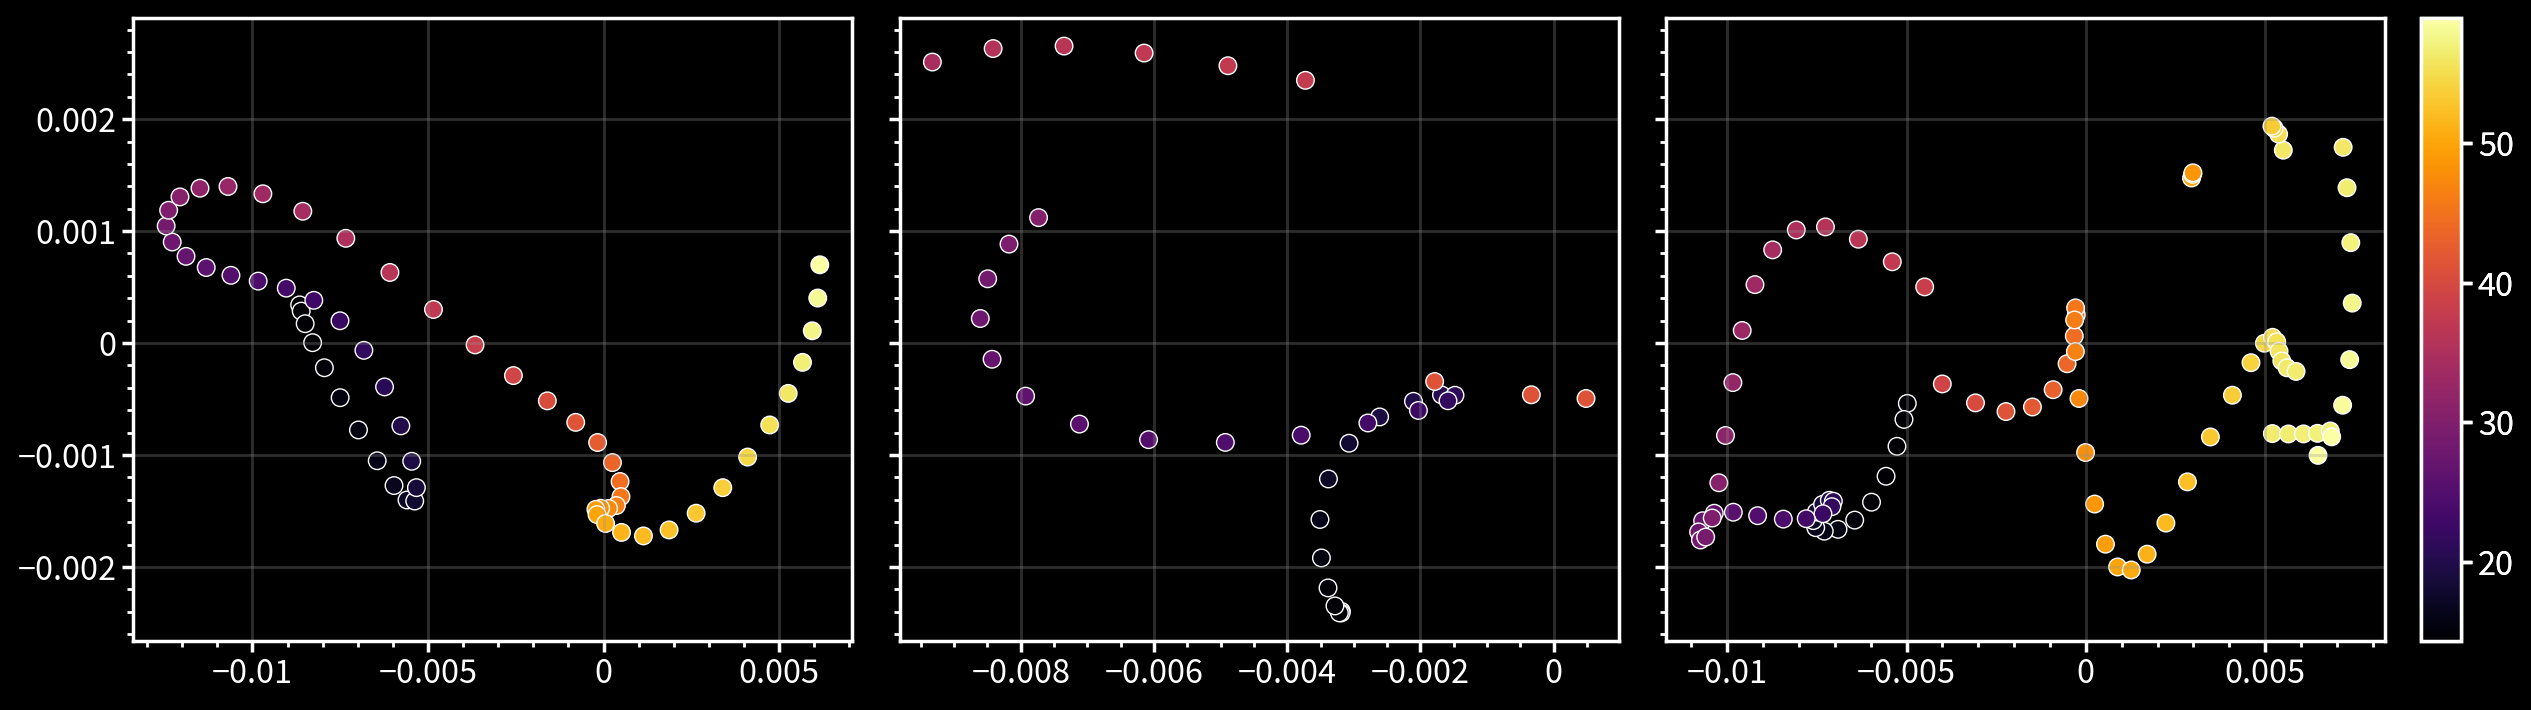

In [73]:
index = 2
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.595,refaspect=1.1531)
ct0 = axs[0].scatter(np.ma.masked_where(meanWSURF>59,meanPC2),np.ma.masked_where(meanWSURF>59,meanPC6), 
                    s= 40, c = meanWSURF, cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59) #variance:{(pcex[index[i]]*100):.1f}%'
#index = 12
ct1 = axs[1].scatter(np.ma.masked_where(meanWSURF_1>59,meanPC2_1),np.ma.masked_where(meanWSURF_1>59,meanPC6_1), 
                    s= 40, c = meanWSURF_1, cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59) #variance:{(pcex[index[i]]*100):.1f}%'
ct2 = axs[2].scatter(np.ma.masked_where(meanWSURF_2>59,meanPC2_2),np.ma.masked_where(meanWSURF_2>59,meanPC6_2), 
                    s= 40, c = meanWSURF_2, cmap='inferno',linewidths=0.5, edgecolors='w',vmax=59)
axs.grid(alpha=0.3,color='gray',linewidth=1)
plt.colorbar(ct0)
plt.show()

In [4]:
def output_realdterms(category='train',varnum=2,LT=24):
    if varnum==2:
        a,b,_,_ = retrieve_cartesian(PCA_dict=None,Af_dict=haiyan_data,numcomp=None,LT=24,forecastPC=None,\
                                  target='all',suffix=suffix).windrates_real(uvwheatpath='TCGphy/testML/output/haiyan/processed/uvwheat/',\
                                                                             LT=LT,category=category,validindex=[1,6],testindex=[2,12])
        return a,b
    elif varnum==4:
        a,b,c,d = retrieve_cartesian(PCA_dict=None,Af_dict=haiyan_data,numcomp=None,LT=24,forecastPC=None,\
                                  target='all',suffix=suffix).windrates_real(uvwheatpath='TCGphy/testML/output/haiyan/processed/uvwheat/',\
                                                                             LT=LT,category=category,validindex=[1,6],testindex=[2,12])
        return a,b,c,d

lti=24
realdu,realdv = output_realdterms(category='train',varnum=2,LT=lti)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

PCA files
--------------------------------------------
Just use the inputs

In [6]:
lti = 24
model = read_and_proc.depickle('../output/haiyan/processed/pca/FFW/'+str(lti)+'/FFWmodels_cross7')
new_feature = read_and_proc.depickle('../output/haiyan/processed/pca/FFW/'+str(lti)+'/newfeature_cross7')
reducedX = read_and_proc.depickle('../output/haiyan/processed/pca/FFW/'+str(lti)+'/reducedX_cross7')

In [124]:
percentiles2 = [np.percentile((reducedX[5][:,-9]),i) for i in np.linspace(10,90,18)]
percentiles6 = [np.percentile((reducedX[5][:,-5]),i) for i in np.linspace(10,90,18)]

In [90]:
list_pca2 = sorted(list(np.asarray(percentiles2)*-1)+percentiles2)
list_pca6 = sorted(list(np.asarray(percentiles6)*-1)+percentiles6)

In [101]:
len(list_pca2)

18

In [137]:
TESTsurfmax = surf_dwspdmax.copy()*(60*60)

In [138]:
TESTij = np.zeros((17,17))
for i in range(17):
    for j in range(17):
        testa = TESTsurfmax[(reducedX[5][:,-9]>percentiles2[0+i]) & (reducedX[5][:,-9]<percentiles2[1+i]) & (reducedX[5][:,-5]>percentiles6[0+j]) & (reducedX[5][:,-5]<percentiles6[1+i])]
        if len(testa)>5:
            TESTij[i,j] = np.nanmean(testa)
        else:
            TESTij[i,j] = np.nan

/tmp/ipykernel_3739767/4156205420.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 13,'linewidth':1.25})


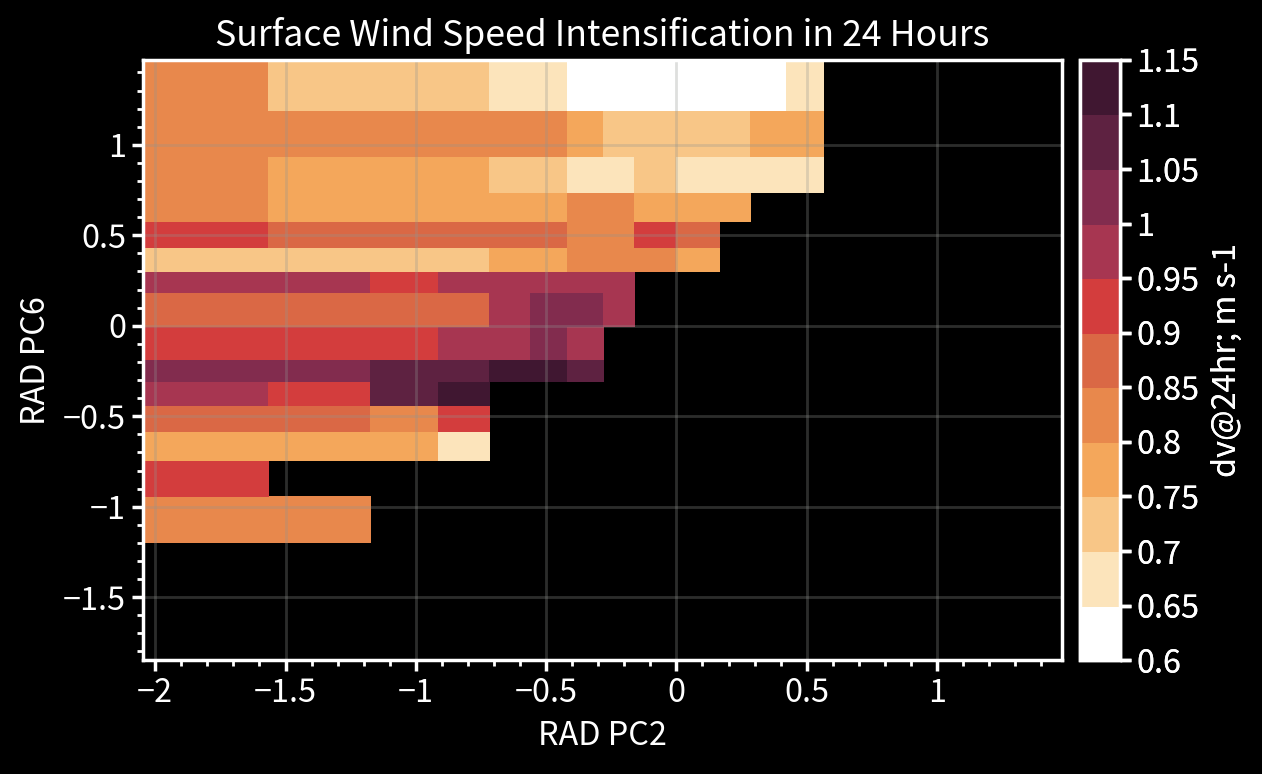

In [149]:
plot.rc.metacolor = 'w'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 13,'linewidth':1.25})
plot.rc.axesfacecolor = 'k'

pcex = PCAdict['hdia'].explained_variance_ratio_
index,varN = [12,5,8],['V','U','U']
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.595,refaspect=1.531)
img=axs[0].pcolormesh(list_pca2[:-1],list_pca6[:-1],TESTij,cmap='fire')
axs[0].colorbar(img,loc='r',label='dv@24hr; m s-1')
axs[0].format(ylabel='RAD PC6',xlabel='RAD PC2',title=f'Surface Wind Speed Intensification in 24 Hours') #variance:{(pcex[index[i]]*100):.1f}%'
axs[0].grid(alpha=0.3,color='gray',linewidth=1)
plt.savefig('../figures/0505/PC2PC6_to_surfwspdINTEN.png',dpi=400,facecolor=fig.get_facecolor())
plt.show()